# Satellite Lake Water Temperature

This dataset provides mid-morning daily lake surface water temperature (LSWT) values derived from satellite data, along with associated uncertainty and quality levels. The data, retrieved from ATSR and AVHRR sensors, have been bias-adjusted for consistency and may contain gaps due to missing observations. LSWT is an essential climate variable critical for understanding lake ecology, hydrological processes, and large-scale climate interactions, with data development supported by the UK NERC GloboLakes project and future enhancements from the ESA Climate Change Initiative.

**Information on Dataset:**
* Source: [Satellite Lake Water Temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview)
* Author:
* Notebook Version: 1.3 (Updated: December 03, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\satellite-lake-water-temperature\download"
working_folder = r".\data\satellite-lake-water-temperature\working"
geotiff_folder = r".\data\satellite-lake-water-temperature\geotiff"
csv_folder = r".\data\satellite-lake-water-temperature\csv"
output_folder = r".\data\satellite-lake-water-temperature\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool: https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_constance = [48.0, 8.7, 47.3, 9.9]  # [North, West, South, East]

# Different data versions are available depending on the year of interest.
year = 2008
version = "4_5_1" if year <= 2020 else "4_5_2"

In [4]:
dataset = "satellite-lake-water-temperature"
request = {
    "variable": "all",
    "year": [f"{year}"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": version,
    "area": bbox_wgs84_constance
}

In [5]:
# Uncomment and run this cell to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}_{request['year'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)
    
    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")
        
if __name__ == "__main__":
    client = main()
    main_retrieve()

2024-12-11 17:23:41,020 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.


2024-12-11 17:23:41,021 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2024-12-11 17:23:41,022 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**


2024-12-11 17:23:41,023 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip folder

In [6]:
import zipfile

# Construct the dataset filename and path
dataset_filename = f"{dataset}_{year}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = os.path.join(working_folder, str(year))

# Extract the zip file
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Merge Yearly NetCDF4 Files into a Single NetCDF4 File

In [7]:
import xarray as xr

# Filter the list of filenames
nc_filepath_merged = os.path.join(output_folder,f"{dataset}_{year}.nc")

if not os.path.isfile(nc_filepath_merged):
    filename_list = os.listdir(extract_folder)

    # Load all NetCDF files into a list of datasets
    datasets = [xr.open_dataset(os.path.join(extract_folder, f)) for f in filename_list]
    merged_dataset = xr.concat(datasets, dim='time')

    # Save the merged dataset into a new NetCDF file
    merged_dataset.to_netcdf(nc_filepath_merged)
    print(f"New NetCDF4 file created at {nc_filepath_merged} for year {year}")
else:
    print(f"{nc_filepath_merged} already exists.")

.\data\satellite-lake-water-temperature\output\satellite-lake-water-temperature_2008.nc already exists.


## 4. Read the merged netCDF4 file and print the metadata

In [8]:
import netCDF4 as nc
import numpy as np
import pandas as pd

# Open the NetCDF file in read mode
dataset = nc.Dataset(nc_filepath_merged, mode="r")

# List all variables in the dataset
variables_list = dataset.variables.keys()
df_var_units = pd.DataFrame(
    {
        "Variable": list(variables_list),
        "Dimension": [np.shape(dataset[variable]) for variable in list(variables_list)],
        "Unit": [
            (
                dataset.variables[variable].units
                if hasattr(dataset.variables[variable], "units")
                else "NA"
            )
            for variable in variables_list
        ],
    }
)

# Extract coordinate data and the primary variable's data
lon_list = dataset['lon'][:]
lat_list = dataset['lat'][:]

In [9]:
test_variable = 'lake_surface_water_temperature'
variable_data = dataset[test_variable]

# Generate summary of the primary variable
summary = {
    "Variable Name": test_variable,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{test_variable}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,lake_surface_water_temperature
1,Data Type,int16
2,Shape,"(366, 14, 24)"
3,Variable Info,"lake_surface_water_temperature(time, lat, lon)"
4,Units,kelvin
5,Long Name,lake surface skin water temperature


## 5. Export merged netCDF4 file to GeoTIFF

### 5.1 V1: Exported GeoTIFF aligns with the NetCDF4 data in QGIS

In [10]:
# import rasterio
# from rasterio.transform import from_origin
# import netCDF4 as nc

# first_band = 0
# last_band = 363
# bands_to_export = range(first_band, last_band + 1)
# variable_name = 'lake_surface_water_temperature'
# output_file = r"G:/lake_surface_water_temperature_merged.tif"

# # read
# dataset = nc.Dataset(nc_filepath_merged, mode='r')

# temperature = dataset[variable_name][:]
# lon_list = dataset['lon'][:]
# lat_list = dataset['lat'][:]
# time_var = dataset.variables['time']
# time_units = dataset.variables['time'].units
# time_calendar = getattr(time_var, "calendar", "standard")
# cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

# # transform
# pixel_size_lat = (lat_list.max() - lat_list.min()) / (len(lat_list) - 1)
# pixel_size_lon = (lon_list.max() - lon_list.min()) / (len(lon_list) - 1)
# transform = from_origin(lon_list.min() - pixel_size_lon / 2,
#                         lat_list.min() - pixel_size_lat / 2,
#                         pixel_size_lon,
#                         -pixel_size_lat
#                         )

# ## Standard transform is
# # transform = from_origin(lon.min(), lat.max(), pixel_size_lon, pixel_size_lat)
# # followed by 90deg rotation and flipping
# # However, this creates geotiff that is shifted by half pixel right and half pixel down

# # subset
# temperature_subset = temperature[bands_to_export, :, :]
# cftime_subset = cftime[bands_to_export]

# # metadata for geotiff
# meta = {
#     "driver": "GTiff",
#     "dtype": str(temperature_subset.dtype),
#     "nodata": -9999,
#     "width": temperature_subset.shape[2],
#     "height": temperature_subset.shape[1],
#     "count": temperature_subset.shape[0],
#     "crs": "EPSG:4326",
#     "transform": transform,
# }

# with rasterio.open(output_file, "w", **meta) as dst:
#     for band in range(temperature_subset.shape[0]):
#         dst.write(temperature_subset[band, :, :], band + 1)
#         dst.set_band_description(band + 1, f"{cftime_subset[band]}")
        
# print(f"Merged GeoTIFF saved as {output_file}")

### 5.2 V2: From Tim

In [11]:
# import rasterio
# from rasterio.transform import from_origin
# from rasterio.crs import CRS
# import numpy as np
# from netCDF4 import num2date

# crs = CRS.from_epsg(4326)
# ds = nc.Dataset(nc_filepath_merged, 'r')

# lat = ds.variables['lat'][:]
# lon = ds.variables['lon'][:]
# time_var = ds.variables['time']
# time_units = ds.variables['time'].units

# pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
# pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
# transform = from_origin(lon.min(), lat.max(), pixel_size_lon, pixel_size_lat)

# unprocessed_dir = r"G:/"

# t = 341
# data = ds.variables[variable_name][t, :, :]
# data[data == data.fill_value] = -9999
# year = int(num2date(time_var[t], time_units).year)

# geotiff_path = os.path.join(unprocessed_dir, f'unprocessed.tiff')
# with rasterio.open(
#     geotiff_path,
#     'w',
#     driver='GTiff',
#     height=data.shape[0],
#     width=data.shape[1],
#     count=1,
#     dtype=data.dtype,
#     crs=crs,
#     transform=transform,
#     nodata=-9999
# ) as dst:
#     dst.write(data, 1)

# rotated_data = np.rot90(data, k=2)
# flipped_data = np.fliplr(rotated_data)

# processed_path = os.path.join(unprocessed_dir, f'processed.tiff')
# with rasterio.open(
#     processed_path,
#     'w',
#     driver='GTiff',
#     height=flipped_data.shape[0],
#     width=flipped_data.shape[1],
#     count=1,
#     dtype=flipped_data.dtype,
#     crs=crs,
#     transform=transform,
#     nodata=-9999
# ) as dst:
#     dst.write(flipped_data, 1)
# ds.close()

### 5.3 V3: Similar to Tim's but without rotation and flip

In [12]:
# crs = CRS.from_epsg(4326)
# ds = nc.Dataset(nc_filepath_merged, 'r')

# lat = ds.variables['lat'][:]
# lon = ds.variables['lon'][:]
# time_var = ds.variables['time']
# time_units = ds.variables['time'].units

# pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
# pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)

# # Modified transform
# transform = from_origin(lon.min(), lat.min()-pixel_size_lat, pixel_size_lon, -pixel_size_lat)

# output_dir = r"G:/"

# t = 341
# data = ds.variables[variable_name][t, :, :]
# data[data == data.fill_value] = -9999
# year = int(num2date(time_var[t], time_units).year)

# processed_path = os.path.join(output_dir, f'processed_without_rotation_and_flip.tiff')
# with rasterio.open(
#     processed_path,
#     'w',
#     driver='GTiff',
#     height=data.shape[0],
#     width=data.shape[1],
#     count=1,
#     dtype=data.dtype,
#     crs=crs,
#     transform=transform,
#     nodata=-9999
# ) as dst:
#     dst.write(data, 1)

# ds.close()

## 6. Create Dataframe and Export as CSV

### 4.1 Daily average

In [13]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
import numpy as np

def netcdf_to_dataframe(nc_file):
    # Open the dataset
    with nc.Dataset(nc_file, "r") as dataset:
        # Extract and decode time variable
        time_var = dataset.variables["time"]
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Datums- und Uhrzeitliste separat erstellen
        date_list = [t.strftime('%Y-%m-%d') for t in cftime]
        time_list = [t.strftime('%H:%M:%S') for t in cftime]
        date_objects = [datetime.strptime(d, '%Y-%m-%d').date() for d in date_list]
        time_objects = [datetime.strptime(t, '%H:%M:%S').time() for t in time_list]

        # Extract and calculate mean temperature efficiently
        temperature_data = dataset.variables["lake_surface_water_temperature"][:]
        temperature_data_units = dataset.variables["lake_surface_water_temperature"].units
        temperature_mean_list = np.nanmean(temperature_data, axis=(1, 2))
        temperature_std_list = np.nanstd(temperature_data, axis=(1, 2))
        nonzero_count_list = np.count_nonzero(~np.isnan(temperature_data), axis=(1,2))

        lswt_uncertainty = dataset.variables["lswt_uncertainty"][:]
        lswt_uncertainty_units = dataset.variables["lswt_uncertainty"].units
        lswt_uncertainty_mean_list = np.nanmean(lswt_uncertainty, axis=(1, 2))
        
        lswt_quality_level = dataset.variables["lswt_quality_level"][:]
        lswt_quality_level_mean_list = np.nanmean(lswt_quality_level, axis=(1, 2))

        # Create DataFrame
        df = pd.DataFrame(
            {
                "Time": cftime,
                f"Mean Temperature ({temperature_data_units.capitalize()})": temperature_mean_list,
                "Standard Deviation": temperature_std_list,
                f"Uncertainty ({lswt_uncertainty_units.capitalize()})": lswt_uncertainty_mean_list,
                f"Quality Level": lswt_quality_level_mean_list,
                "Non-Zero Count":nonzero_count_list,
                "Date": date_objects,
                "Time (Hour)": time_objects,
            }
        )
        
        return df.set_index("Time")        

df = netcdf_to_dataframe(nc_filepath_merged)

In [14]:
# Filter NaN values
df_filterd_daily = df.dropna()

# Definiere den Pfad zur CSV-Datei
csv_path = os.path.join(csv_folder, f"satellite-lake-water-temperature_{year}.csv")

if not os.path.isfile(csv_path):
    df_filterd_daily.to_csv(csv_path)
    print(f"Summary data exported to {csv_path}")
else:
    print(f"{csv_path} file already exists. Skipping export.")

df_filterd_daily.head(5)

.\data\satellite-lake-water-temperature\csv\satellite-lake-water-temperature_2008.csv file already exists. Skipping export.


,Mean Temperature (Kelvin),Standard Deviation,Uncertainty (Kelvin),Quality Level,Non-Zero Count,Date,Time (Hour)
Time,,,,,,,
2008-01-01 12:00:00,276.447845,1.488536,0.365143,3.285714,14.0,2008-01-01,12:00:00
2008-01-02 12:00:00,277.639465,0.882013,0.313083,4.250000,36.0,2008-01-02,12:00:00
2008-01-04 12:00:00,276.682312,0.806210,0.245308,3.846154,13.0,2008-01-04,12:00:00
2008-01-05 12:00:00,275.202484,0.584692,0.275750,3.000000,4.0,2008-01-05,12:00:00
2008-01-06 12:00:00,276.217987,2.356976,0.501800,1.266667,15.0,2008-01-06,12:00:00


### 4.2 Plot daily average

> Note: Due to limited daily/monthly data for 2023 dataset, **Plots** do not work properly

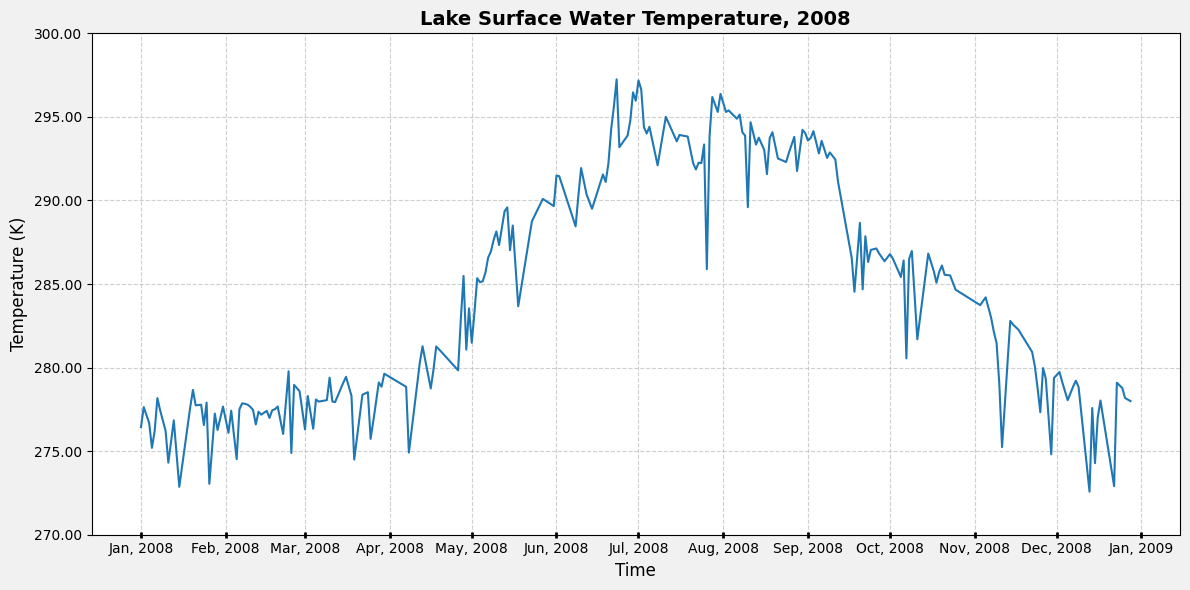

In [15]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

ax.set_ylim(270, 300)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

line1, = ax.plot(df_filterd_daily['Date'], df_filterd_daily['Mean Temperature (Kelvin)'])

plt.tight_layout()
plt.show()

### 5.2 Monthly average

In [16]:
df_filterd_monthly = (
    df_filterd_daily.groupby(pd.PeriodIndex(df_filterd_daily["Date"], freq="M"))[
        ["Mean Temperature (Kelvin)", "Uncertainty (Kelvin)", "Quality Level"]
    ]
    .mean()
    .reset_index()
)

df_filterd_monthly['Date'] = df_filterd_monthly['Date'].dt.to_timestamp()
df_filterd_monthly.head()

,Date,Mean Temperature (Kelvin),Uncertainty (Kelvin),Quality Level
0,2008-01-01,276.600464,0.262076,3.373495
1,2008-02-01,277.301971,0.243119,3.784018
2,2008-03-01,277.941254,0.311691,3.628039
3,2008-04-01,280.694550,0.359485,3.116261
4,2008-05-01,286.889282,0.371748,3.896243


In [17]:
# Calculate uncertainty using Error Propagation

df_filterd_monthly = (
    df_filterd_daily.groupby(pd.PeriodIndex(df_filterd_daily["Date"], freq="M"))[[
        "Mean Temperature (Kelvin)", "Uncertainty (Kelvin)", "Standard Deviation"
    ]]
    .agg({
        "Mean Temperature (Kelvin)": "mean",
        "Uncertainty (Kelvin)": lambda x: (x**2).mean()**0.5,
        "Standard Deviation": lambda x: (x**2).mean()**0.5
    })
    .reset_index()
)

df_filterd_monthly['Date'] = df_filterd_monthly['Date'].dt.to_timestamp()
df_filterd_monthly

,Date,Mean Temperature (Kelvin),Uncertainty (Kelvin),Standard Deviation
0,2008-01-01,276.600464,0.270412,1.104087
1,2008-02-01,277.301971,0.251805,0.753740
2,2008-03-01,277.941254,0.317502,0.679566
3,2008-04-01,280.694550,0.361687,1.431591
4,2008-05-01,286.889282,0.396884,1.244906
5,2008-06-01,292.766418,0.598463,0.941214
6,2008-07-01,293.741150,0.604483,0.903266
7,2008-08-01,293.522034,0.634262,0.979820
8,2008-09-01,289.624420,0.515896,0.500452
9,2008-10-01,285.385895,0.437987,0.403448


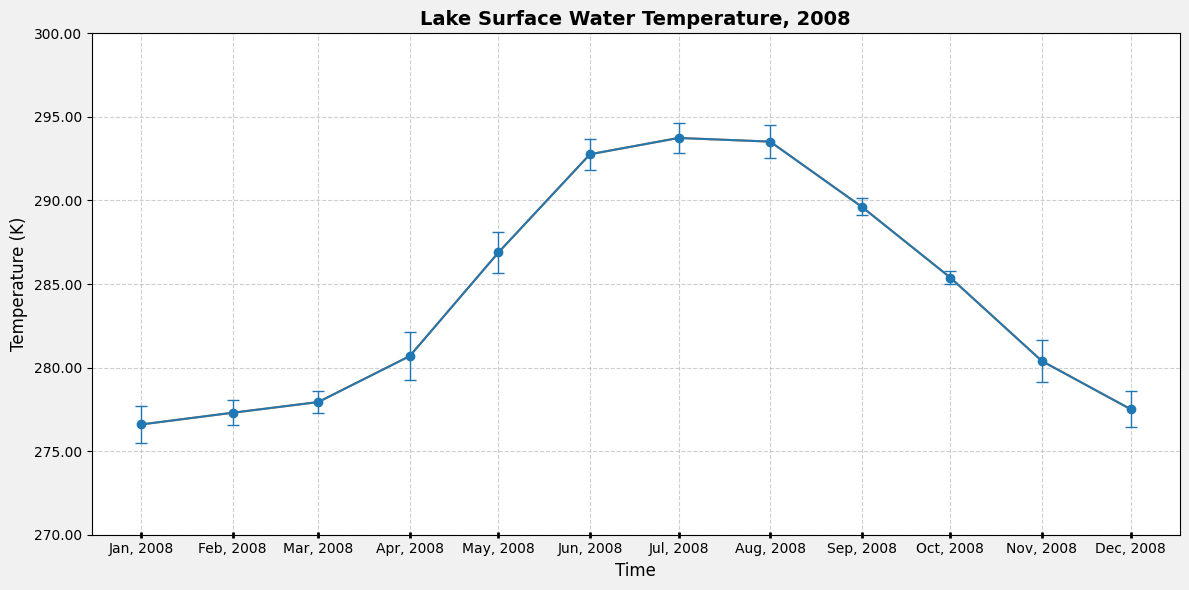

In [18]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

ax.set_ylim(270, 300)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

ax.errorbar(
    df_filterd_monthly['Date'],
    df_filterd_monthly['Mean Temperature (Kelvin)'],
    yerr=df_filterd_monthly['Standard Deviation'],
    fmt='o-',  # Marker and line style
    label='Mean Temperature ± Uncertainty',
    capsize=4,  # Add caps to the error bars
    elinewidth=1,  # Thickness of error bars
    capthick=1,  # Thickness of caps
)

line1, = ax.plot(df_filterd_monthly['Date'], df_filterd_monthly['Mean Temperature (Kelvin)'])

plt.tight_layout()
plt.show()

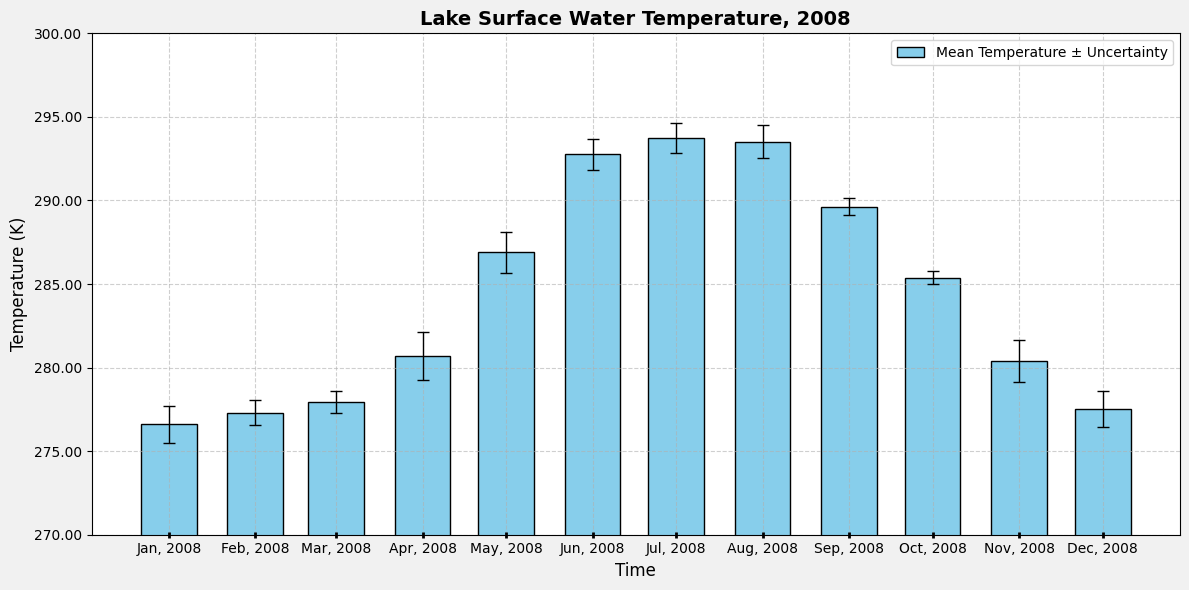

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

ax.set_ylim(270, 300)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Bar plot with error bars and adjusted width
ax.bar(
    df_filterd_monthly['Date'],
    df_filterd_monthly['Mean Temperature (Kelvin)'],
    yerr=df_filterd_monthly['Standard Deviation'],
    color='skyblue',
    edgecolor='black',
    width=20,
    label='Mean Temperature ± Uncertainty',
    capsize=4,
    error_kw=dict(elinewidth=1, capthick=1),
)

plt.tight_layout()
plt.legend()
plt.show()

### 5.3 Plot using cmap

In [20]:
max_value = df['Non-Zero Count'].max()
rows_with_max_count = df.loc[df['Non-Zero Count'] == max_value]
row_number = df.index.get_loc(df['Non-Zero Count'].idxmax())

print(row_number)
rows_with_max_count

23


,Mean Temperature (Kelvin),Standard Deviation,Uncertainty (Kelvin),Quality Level,Non-Zero Count,Date,Time (Hour)
Time,,,,,,,
2008-01-24 12:00:00,276.567902,1.40774,0.226417,3.666667,48.0,2008-01-24,12:00:00


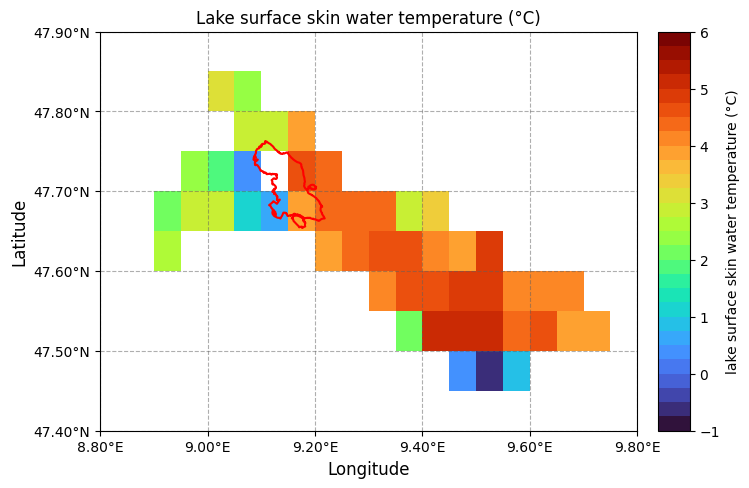

In [21]:
import geopandas as gpd
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Function to format latitude tick labels
def format_latitude(x, pos):
    return f"{x:.2f}°N"

# Function to format longitude tick labels
def format_longitude(x, pos):
    return f"{x:.2f}°E"

with nc.Dataset(nc_filepath_merged, "r") as dataset:
    variable_data = dataset["lake_surface_water_temperature"]
        
    band_data = variable_data[row_number, :, :] - 273.15
    vmin = np.round(np.floor(np.nanmin(band_data)), 1)
    vmax = np.round(np.ceil(np.nanmax(band_data)), 1)
    bins = int((vmax-vmin)/0.25)
    
    # Plot the data using matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Load predefined colormap
    cmap = plt.get_cmap("turbo", bins)
    
    # Create a pseudo-color plot for the data
    pcm = ax.pcolormesh(
        lon_list,
        lat_list,
        band_data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    
    # Add administrative boundary of Konstanz (Shapefile)
    konstanz_shp = r".\shapefiles\kn_boundary.shp"
    konstanz_boundary = gpd.read_file(konstanz_shp)
    konstanz_boundary.boundary.plot(ax=ax, edgecolor='red')
    
    # Plot color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=-1.1)
    plt.colorbar(pcm, cax=cax, label=f'{summary["Long Name"]} (°C)')
    
    # Add grid lines
    ax.grid(visible=True, which='major', color='#5f5f5f', linestyle='--', alpha=0.5)
    
    # Set custom tick formatters for latitude and longitude
    ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
    ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))
    
    ax.set_xlim(8.8,9.8)
    ax.set_ylim(47.4,47.9)

    ax.set_title(f'{(summary["Long Name"]).capitalize()} (°C)')
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()